# Import and install requirements

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os

directory = os.getcwd().split('/')[-1]

if directory == 'content':
    %cd drive/MyDrive/TDT17/notebooks

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone

directory = os.getcwd().split('/')[-1]
if directory != 'yolov5':
  %cd yolov5

!pip install -qr requirements.txt
!pip install -U albumentations
!pip install wandb

project_name = 'tdt17-yolo-ai-gutta'

fatal: destination path 'yolov5' already exists and is not an empty directory.
/Users/magnus/repos/lidar-object-detection/notebooks/yolov5


## Setup Weights and Biases

In [5]:
import wandb
wandb.login()

wandb: Currently logged in as: magssch (use `wandb login --relogin` to force relogin)


True

## Init Yolov5

In [3]:
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-114-ga4207a2 torch 1.10.0 CPU


Setup complete ✅


# Parse dataset

In [4]:
import shutil

directory = os.getcwd().split('/')[-1]
if directory == 'yolov5':
  %cd ../

directory = os.getcwd().split('/')[-1]
if directory == 'notebooks':
  %cd ../

delete = None
while delete != "y" and delete != "n":
  delete = input('Delete already existing files? (y/n): ')

if delete == "y":
  if os.path.isdir('data/all_videos_merged'):
    shutil.rmtree('data/all_videos_merged/')
  if os.path.isdir('data/all_videos'):
    shutil.rmtree('data/all_videos/')
  if os.path.isdir('data/all_videos_split'):
    shutil.rmtree('data/all_videos_split/')

merge_images = None
while merge_images != "y" and merge_images != "n":
  merge_images = input('Combine images to RGB? (y/n): ')

patches = None
while merge_images == "y" and patches != "y" and patches != "n":
  patches = input('Split each image into 8x 128x128 patches? (y/n): ')

if patches == "y":
  if not os.path.isdir('data/all_videos_merged'):
    !python ./src/dataset_builder.py --merge --patches
elif merge_images == "y":
  if not os.path.isdir('data/all_videos_merged'):
    !python ./src/dataset_builder.py --merge
else: 
  if not os.path.isdir('data/all_videos'):
    !python ./src/dataset_builder.py

directory = os.getcwd().split('/')[-1]
if directory != 'notebooks':
  %cd ./notebooks/yolov5/

/Users/magnus/repos/lidar-object-detection/notebooks
/Users/magnus/repos/lidar-object-detection
/Users/magnus/repos/lidar-object-detection/notebooks/yolov5


In [5]:
dataset_path = "all_videos_merged" if merge_images else "all_videos"

# Test labels

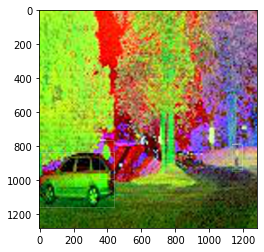

In [6]:
import random
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
Image.MAX_IMAGE_PIXELS = None
plt.rcParams["figure.figsize"] = (40,4)

annotations = [os.path.join(f'../../data/{dataset_path}/labels', x) for x in os.listdir(f'../../data/{dataset_path}/labels') if x[-3:] == "txt"]

class_name_to_id_mapping = {"car": 0, "truck": 1, "bus": 2, "motorcycle": 3, "bicycle": 4, "scooter": 5, "person": 6, "rider": 7}

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
contains_annotations = False
while not contains_annotations:
  with open(annotation_file, "r") as file:
      annotation_list = file.read().split("\n")[:-1]
      if len(annotation_list) < 1:
        annotation_file = random.choice(annotations)
        continue
      annotation_list = [x.split(" ") for x in annotation_list]
      annotation_list = [[float(y) for y in x ] for x in annotation_list]
      contains_annotations = True

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

image = Image.open(image_file)
# resize image and save
half = 10
image = image.resize( [int(half * s) for s in image.size] )

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

## Folder shortcuts

In [7]:
data_folder = '../../data'
videos_folder = '../../videos'

In [25]:
images_count = len(os.listdir(f'{data_folder}/{dataset_path}/images'))
labels_count = len(os.listdir(f'{data_folder}/{dataset_path}/labels'))
#assert images_count == labels_count, 'images and labels count do not match'

# Split dataset



In [27]:
from sklearn.model_selection import train_test_split
# Read images and annotations
images = [os.path.join(f'{data_folder}/{dataset_path}/images', x) for x in os.listdir(f'{data_folder}/{dataset_path}/images')]
annotations = [os.path.join(f'{data_folder}/{dataset_path}/labels', x) for x in os.listdir(f'{data_folder}/{dataset_path}/labels') if x[-3:] == "txt"]

images.sort()
annotations.sort()


image_to_annotation_file = {}
label_index = 0
for image_path in images:
  image_file = image_path.split("/")[-1].split(".")[0]
  label_file = annotations[label_index].split("/")[-1].split(".")[0]
  if image_file == label_file:
    image_to_annotation_file[image_path] = annotations[label_index]
    label_index += 1

# Split the dataset into train-valid splits 
train_images, val_images = train_test_split(images, test_size = 0.1, random_state = 1)
train_annotations = [image_to_annotation_file[image_path] for image_path in train_images if image_path in image_to_annotation_file]
val_annotations = [image_to_annotation_file[image_path] for image_path in val_images if image_path in image_to_annotation_file]
  
#train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.1, random_state = 1)
#val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

KeyError: '../../data/all_videos_merged/images/Video00004_frame_000055_patch_7.jpg'

In [15]:
!mkdir ../../data/all_videos_split/ ../../data/all_videos_split/images ../../data/all_videos_split/labels 
!mkdir ../../data/all_videos_split/images/train ../../data/all_videos_split/images/val/ ../../data/all_videos_split/labels/train ../../data/all_videos_split/labels/val

mkdir: ../../data/all_videos_split/: File exists
mkdir: ../../data/all_videos_split/images: File exists
mkdir: ../../data/all_videos_split/labels: File exists
mkdir: ../../data/all_videos_split/images/train: File exists
mkdir: ../../data/all_videos_split/images/val/: File exists
mkdir: ../../data/all_videos_split/labels/train: File exists
mkdir: ../../data/all_videos_split/labels/val: File exists


In [16]:
import shutil
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, f'{data_folder}/all_videos_split/images/train')
move_files_to_folder(val_images, f'{data_folder}/all_videos_split/images/val')
#move_files_to_folder(test_images, f'{data_folder}/all_videos_split/images/test')
move_files_to_folder(train_annotations, f'{data_folder}/all_videos_split/labels/train')
move_files_to_folder(val_annotations, f'{data_folder}/all_videos_split/labels/val')
#move_files_to_folder(test_annotations, f'{data_folder}/all_videos_split/labels/test')

# Training

In [17]:
!python train.py \
  --data {data_folder}/lidar.yaml \
  --weights yolov5s.pt \
  --img 128 \
  --batch 16 \
  --epochs 25 \
  --project {project_name} \
  --upload_dataset \
  --bbox_interval 1 \
  --save-period 1

# --data {data_folder}/lidar.yaml \

^C
Traceback (most recent call last):
  File "/Users/magnus/repos/lidar-object-detection/notebooks/yolov5/train.py", line 19, in <module>
    import torch
  File "/Users/magnus/repos/lidar-object-detection/venv/lib/python3.9/site-packages/torch/__init__.py", line 29, in <module>
    from .torch_version import __version__ as __version__
  File "/Users/magnus/repos/lidar-object-detection/venv/lib/python3.9/site-packages/torch/torch_version.py", line 3, in <module>
    from pkg_resources import packaging  # type: ignore[attr-defined]
  File "/Users/magnus/repos/lidar-object-detection/venv/lib/python3.9/site-packages/pkg_resources/__init__.py", line 3248, in <module>
    def _initialize_master_working_set():
  File "/Users/magnus/repos/lidar-object-detection/venv/lib/python3.9/site-packages/pkg_resources/__init__.py", line 3231, in _call_aside
    f(*args, **kwargs)
  File "/Users/magnus/repos/lidar-object-detection/venv/lib/python3.9/site-packages/pkg_resources/__init__.py", line 3260, in

# Prediction

## Get latest run

In [ ]:
runs = sorted(os.listdir('./tdt17-yolo-ai-gutta'), reverse=True)
latest_run = runs[0]

In [ ]:
if not os.path.isdir('../../detection_runs'):
  !mkdir ../../detection_runs ../../detection_runs/baseline ../../detection_runs/improved

In [ ]:
video_files = sorted(os.listdir(videos_folder))

## Create a baseline

In [ ]:
if len(os.listdir('../../detection_runs/baselin')) < 19*3:
  for file in video_files:
    !python detect.py \
      --source {videos_folder}/{file} \
      --weights yolov5s.pt \e
      --project ../../detection_runs \
      --name baseline \
      --exist-ok
    print(f"Detecting {file} finished")

Streaming output truncated to the last 5000 lines.
video 1/1 (80/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 3 persons, Done. (0.017s)
video 1/1 (81/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 3 persons, Done. (0.016s)
video 1/1 (82/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 5 persons, Done. (0.017s)
video 1/1 (83/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 8 persons, Done. (0.017s)
video 1/1 (84/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 6 persons, Done. (0.017s)
video 1/1 (85/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 4 persons, Done. (0.017s)
video 1/1 (86/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 4 persons, Done. (0.023s)
video 1/1 (87/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 10 persons, Done. (0.016s)
video 1/1 (88/101) /content/

## Run detection with improved weights

In [ ]:
for file in video_files:
  !python detect.py \
    --source {videos_folder}/{file} \
    --weights ./{project_name}/{latest_run}/weights/best.pt \
    --project ../../detection_runs \
    --name improved \
    --exist-ok
  print(f"Detecting {file} finished")

Streaming output truncated to the last 5000 lines.
video 1/1 (80/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 2 cars, 4 persons, Done. (0.016s)
video 1/1 (81/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 5 cars, 6 persons, Done. (0.017s)
video 1/1 (82/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 2 cars, 5 persons, Done. (0.017s)
video 1/1 (83/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 2 cars, 6 persons, Done. (0.016s)
video 1/1 (84/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 2 cars, 5 persons, Done. (0.017s)
video 1/1 (85/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 2 cars, 5 persons, Done. (0.017s)
video 1/1 (86/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640 3 cars, 5 persons, Done. (0.017s)
video 1/1 (87/101) /content/drive/My Drive/TDT17/videos/Video00003_intensity.avi: 96x640